# Fiducial marker transformation
---
Transform a fiducial marker from MNI space to individual space.
The goal is to define loaction of individual's brain region

Example : moving ventral intermediate nucleus (VIM) of thalamus from MNI space to individual space

In [1]:
import numpy as np

import slicer
import Elastix
import JupyterNotebooksLib as slicernb

import sitkUtils as su
import SimpleITK as sitk

In [2]:
def load_nii(path):
    """Load .nii or .nrrd to sitk image"""
    filetype = path.split("\\")[-1].split(".")[-1]

    
    reader = sitk.ImageFileReader()    

    if filetype == "nii" or "gz" :
        reader.SetImageIO("NiftiImageIO")
    elif filetype == "nrrd"  :
        reader.SetImageIO("NrrdImageIO")
    reader.SetFileName(path)

    image = reader.Execute()
    
    return image, reader

In [3]:
def registration_elastix(fixedVolumeNode, movingVolumeNode):
    """general registration using Elastix"""
    
    #set Parmeter
    elastixLogic = Elastix.ElastixLogic()
    parameterFilenames = elastixLogic.getRegistrationPresets()[0][Elastix.RegistrationPresets_ParameterFilenames]  # generic Non-rigid
    #parameterFilenames = elastixLogic.getRegistrationPresets()[1][Elastix.RegistrationPresets_ParameterFilenames] # generic rigid
    
    #set Output
    outputVolumeNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLScalarVolumeNode")
    outputTransformNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLTransformNode")

    #run
    _ =  elastixLogic.registerVolumes(fixedVolumeNode, movingVolumeNode, parameterFilenames = parameterFilenames, outputVolumeNode =  outputVolumeNode, outputTransformNode = outputTransformNode )
    
    return outputVolumeNode, outputTransformNode

In [4]:
def onMarkupChanged(caller,event):
    markupsNode = caller
    sliceView = markupsNode.GetAttribute("Markups.MovingInSliceView")
    movingMarkupIndex = markupsNode.GetDisplayNode().GetActiveControlPoint()
    if movingMarkupIndex >= 0:
        pos = [0,0,0]
        markupsNode.GetNthFiducialPosition(movingMarkupIndex, pos)
        isPreview = markupsNode.GetNthControlPointPositionStatus(movingMarkupIndex) == slicer.vtkMRMLMarkupsNode.PositionPreview
        if isPreview:
            logging.info("Point {0} is previewed at {1} in slice view {2}".format(movingMarkupIndex, pos, sliceView))
        else:
            logging.info("Point {0} was moved {1} in slice view {2}".format(movingMarkupIndex, pos, sliceView))
    else:
        logging.info("Points modified: slice view = {0}".format(sliceView))

def onMarkupStartInteraction(caller, event):
    markupsNode = caller
    sliceView = markupsNode.GetAttribute("Markups.MovingInSliceView")
    movingMarkupIndex = markupsNode.GetDisplayNode().GetActiveControlPoint()
    logging.info("Start interaction: point ID = {0}, slice view = {1}".format(movingMarkupIndex, sliceView))

def onMarkupEndInteraction(caller, event):
    markupsNode = caller
    sliceView = markupsNode.GetAttribute("Markups.MovingInSliceView")
    movingMarkupIndex = markupsNode.GetDisplayNode().GetActiveControlPoint()
    logging.info("End interaction: point ID = {0}, slice view = {1}".format(movingMarkupIndex, sliceView))

In [5]:
def setAllSlicevisibile():
    '''show all views of slices in 3dview'''
    
    layoutManager = slicer.app.layoutManager()
    for sliceViewName in layoutManager.sliceViewNames():    
        controller = layoutManager.sliceWidget(sliceViewName).sliceController()
        controller.setSliceVisible(True)

### Load MNI and add VIM marker

left VIM (-13.05 , -18.38, -2.01) (A Horn et al., 2017)

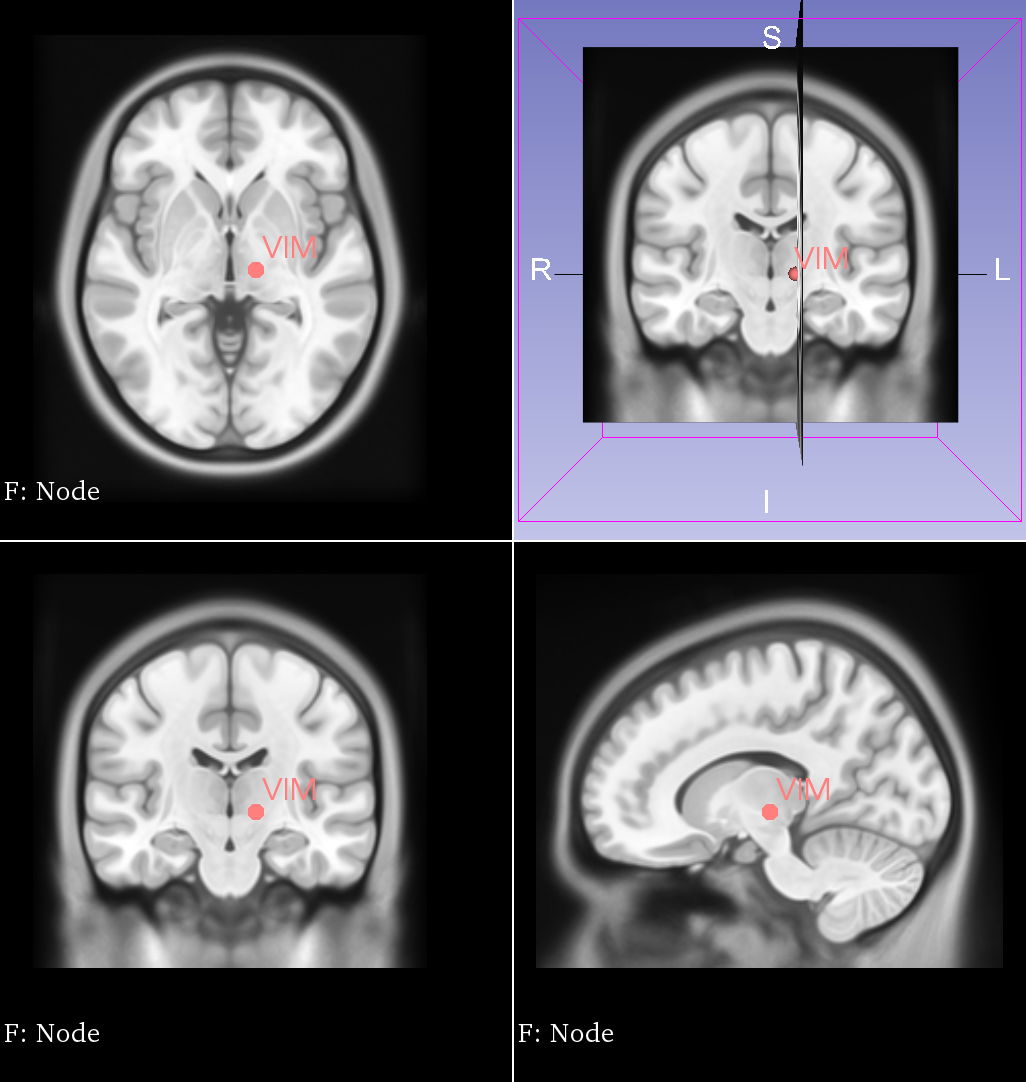

In [15]:
# clear view of 3Dslicer
slicer.mrmlScene.Clear()

Left_VIM = [-13.05 , -18.38, -2.01]

# load local data and push to slicer
MNIimage, _ = load_nii('./data/mni_icbm152_t1_tal_nlin_sym_09c.nii')
MNIvolumeNode = su.PushVolumeToSlicer(MNIimage)
slicer.util.setSliceViewerLayers(foreground=MNIvolumeNode)

# load local data and push to slicer
markupsNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLMarkupsFiducialNode")
markupsNode.CreateDefaultDisplayNodes()
markupsNode.GetDisplayNode().SetGlyphScale(5.0)
#markupsNode.GetDisplayNode().SetGlyphType(13) # chane Glyptype
#markupsNode.GetDisplayNode().SetSelectedColor(1, 0, 0) 

# add fiducial marker at VIM region in MRI
markupsNode.AddFiducial(Left_VIM[0], Left_VIM[1], Left_VIM[2]) #markupsNode.AddControlPoint(vtk.vtkVector3d(-11.0 , -25.0, 2.0))
markupsNode.SetNthFiducialLabel(0, "VIM")

# add event observers
# markupsNode.AddObserver(slicer.vtkMRMLMarkupsNode.PointModifiedEvent, onMarkupChanged)
# markupsNode.AddObserver(slicer.vtkMRMLMarkupsNode.PointStartInteractionEvent, onMarkupStartInteraction)
# markupsNode.AddObserver(slicer.vtkMRMLMarkupsNode.PointEndInteractionEvent, onMarkupEndInteraction)

setAllSlicevisibile()
    

# jump slices to VIM
jump = slicer.modules.markups.logic().JumpSlicesToLocation(-13.05 , -18.38, -2.01, True)
    
display(slicernb.ViewDisplay('FourUp', jump))

### Load indiviual MRI and transform fiducial marker
use transformation matrix of Non-rigid registration


IntProgress(value=0)

Volume registration is started in working directory: C:/Users/user/AppData/Local/Temp/Slicer/Elastix/20211104_140543_507
Register volumes...


toVTKString is deprecated! Conversion is no longer necessary.


Register volumes using: C:\Users\user\AppData\Local\NA-MIC\Slicer 4.11.20210226\NA-MIC\Extensions-29738\SlicerElastix\lib\Slicer-4.11\elastix.exe: ['-f', 'C:/Users/user/AppData/Local/Temp/Slicer/Elastix/20211104_140543_507\\input\\fixed.mha', '-m', 'C:/Users/user/AppData/Local/Temp/Slicer/Elastix/20211104_140543_507\\input\\moving.mha', '-out', 'C:/Users/user/AppData/Local/Temp/Slicer/Elastix/20211104_140543_507\\result-transform', '-p', 'C:\\Users\\user\\AppData\\Local\\NA-MIC\\Slicer 4.11.20210226\\NA-MIC\\Extensions-29738\\SlicerElastix\\lib\\Slicer-4.11\\qt-scripted-modules\\Resources\\RegistrationParameters\\Parameters_Rigid.txt', '-p', 'C:\\Users\\user\\AppData\\Local\\NA-MIC\\Slicer 4.11.20210226\\NA-MIC\\Extensions-29738\\SlicerElastix\\lib\\Slicer-4.11\\qt-scripted-modules\\Resources\\RegistrationParameters\\Parameters_BSpline.txt']
Generate output...
Generate output using: C:\Users\user\AppData\Local\NA-MIC\Slicer 4.11.20210226\NA-MIC\Extensions-29738\SlicerElastix\lib\Slicer

loadNodeFromFile `returnNode` argument is deprecated. Loaded node is now returned directly if `returnNode` is not specified.


Registration is completed
[-12.95113003  -3.83879463  -6.86777953]


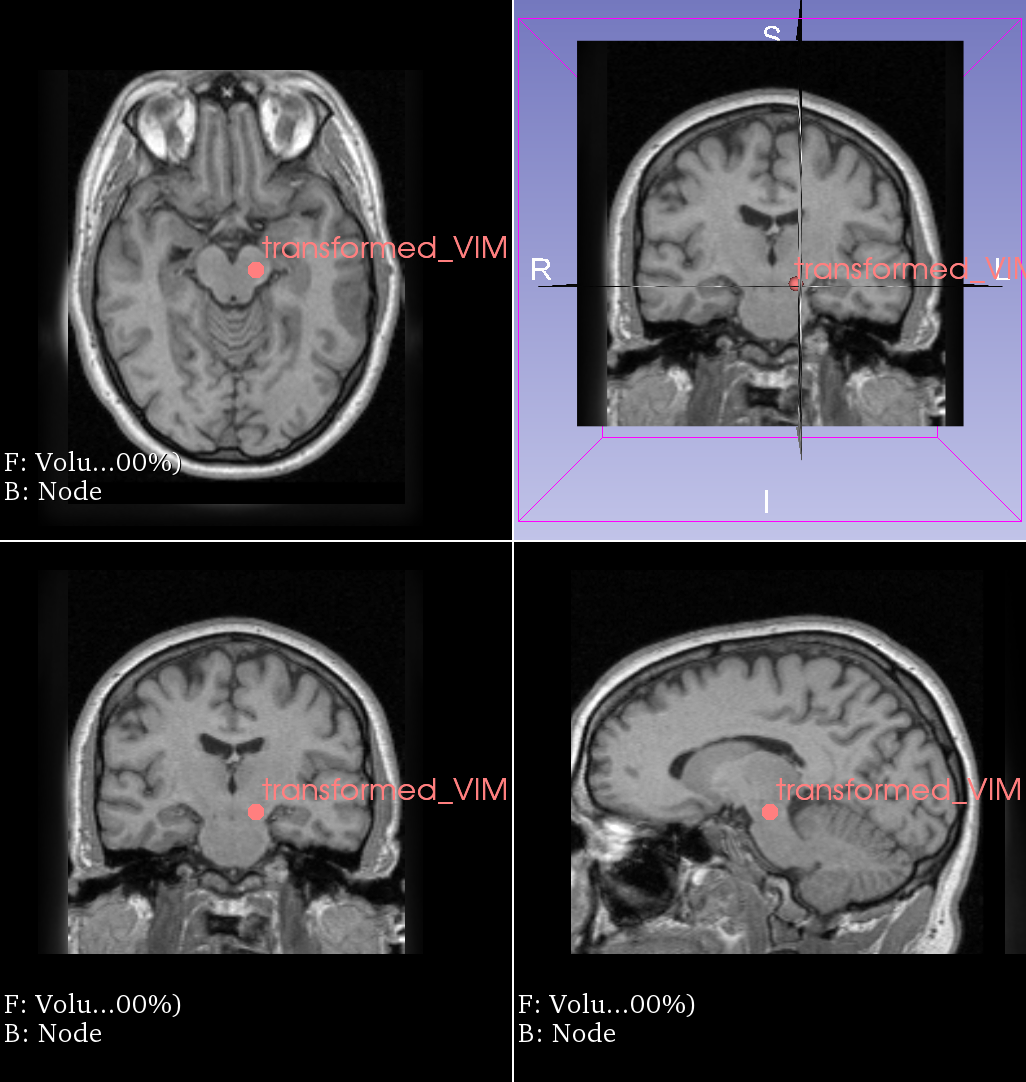

In [16]:
# Load data by downloadFromURL
MRvolumeNode = slicernb.downloadFromURL(uris="https://github.com/Slicer/SlicerTestingData/releases/download/MD5/39b01631b7b38232a220007230624c8e", fileNames="MRHead.nrrd", nodeNames="Volume")

# Get tranform matrix 
MNI_registeredNode, transformNode = registration_elastix(MRvolumeNode, MNIvolumeNode)

# Transform fiduciak marker
markupsNode.SetAndObserveTransformNodeID(transformNode.GetID())
transformed_VIM = slicer.util.arrayFromMarkupsControlPoints(markupsNode, world=True)[0]
markupsNode.SetNthFiducialLabel(0, "transformed_VIM")
print(transformed_VIM)   

setAllSlicevisibile()

# View setting
slicer.util.setSliceViewerLayers(foreground=MRvolumeNode, background=MNIvolumeNode)
slicer.util.setSliceViewerLayers(foregroundOpacity=1)

# jump slices to VIM
jump = slicer.modules.markups.logic().JumpSlicesToLocation(transformed_VIM[0] , transformed_VIM[1], transformed_VIM[2], True)

display(slicernb.ViewDisplay('FourUp', jump))